In [1]:
addprocs(3)
nprocs()

4

In [2]:
@everywhere include("../src/UNSflow.jl")
#@everywhere include("../src/UNSflow.jl")
#@everywhere using UNSflow

 overwritten in module PyPlot at /home/kiran/.julia/v0.5/PyPlot/src/PyPlot.jl:409.
 in module PyPlot at /home/kiran/.julia/v0.5/PyPlot/src/PyPlot.jl:405.
 in module PyPlot at /home/kiran/.julia/v0.5/PyPlot/src/PyPlot.jl:408.
 at /home/kiran/.julia/v0.5/PyPlot/src/PyPlot.jl:413.
}, Base.#step, Any, Any) in module PyPlot overwritten in module PyPlot.
...) in module PyPlot overwritten in module PyPlot.

/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)

/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplo

In [3]:
@everywhere include("../src/UNSflow.jl")
@everywhere using UNSflow

# Recreate Antonio 3D results using a strip theory approach and LDVM

### basic LLT correction - circulation goes to zero at the wingtips. The LDVM runs are done in parallel  


In [81]:
#Construct dimensionless quantities from given values
c_d = 0.2
b_d = 6
AR = b_d/c_d

u_d = 10
f_d = 4.0
k = 2*pi*f_d*c_d/(2*u_d)

#_dAll values below are nondimensional
c = 1
u = 1
w = 2*k
T = (2*pi/w)
ncyc = 1
t_tot = ncyc*T 

modedata = readdlm("../test/anto_mode1.dat");
mode_spl = Spline1D(modedata[:,3],modedata[:,4])

n_span = 12
n_bterm = 40

psi = zeros(n_span)
dpsi = pi/n_span

for i = 1:n_span
    psi[i] = (real(i)-0.5)*dpsi
end

scale = 0.5

#Run LDVM at all these locations:
alpha_amp = 5*pi/180

h_amp = zeros(n_span)
for i = 1:n_span   
    y_d = -b_d*cos(psi[i])/2.
    h_amp[i] = evaluate(mode_spl,y_d)*scale/c_d
end

dtstar = min(0.015,0.015*0.2*4/(k*maximum(h_amp)))
nsteps =round(Int,t_tot/dtstar)+1

alphadef = ConstDef(alpha_amp)
udef = ConstDef(u)
pvt = 0.0 #Doesnt matter, no pitch
lespcrit = [0.21;] #high value to turn off LEV shedding



1-element Array{Float64,1}:
 0.21

In [84]:
nsteps

834

In [85]:
#Time parallel and serial runs

#Parallel

W_mat = Array{Float64,2}[]
W_surf = TwoDSurf[]
W_curfield = TwoDFlowField[]

#Create an aray of inputs for use in pmap. 
#ldvm_in = Tuple{TwoDSurf,TwoDFlowField,Int64,Float64}[]
surf_in = TwoDSurf[]
field_in = TwoDFlowField[]
n_in = Int64[]
dt_in = Float64[]
del_in = DelVortDef[]

for i = 1:Int(n_span/2)
    hdef = CosDef(0., h_amp[i], w, 0.)
    full_kinem = KinemDef(alphadef, hdef, udef)
    surf = TwoDSurf("FlatPlate", pvt, full_kinem, lespcrit)
    curfield = TwoDFlowField()
    del = DelVortDef(1, 500, 10)
    push!(surf_in,surf)
    push!(field_in, curfield)
    push!(n_in,nsteps,)
    push!(dt_in,dtstar)
    push!(del_in,del)
end

@time fullsol = pmap((a1,a2,a3,a4,a5)->ldvm_more(a1,a2,a3,a4),surf_in,field_in,n_in,dt_in,del_in)

for i = 1:Int(n_span/2)
    push!(W_mat,fullsol[i][1])
    push!(W_surf, fullsol[i][2])
    push!(W_curfield, fullsol[i][3])
end
    



 36.937239 seconds (325.53 k allocations: 11.806 MB, 0.06% gc time)


In [86]:
W_mat


6-element Array{Array{Float64,2},1}:
 [0.015 0.0872665 1.11001 1.0 0.052771 11.5718 0.99484 -5.34947 0.0158895 11.6145 0.0174973; 0.03 0.0872665 1.10963 1.0 0.0616951 2.23283 0.17134 -0.97322 0.0190869 2.23926 0.0239156; 0.045 0.0872665 1.109 1.0 0.0707473 2.35971 0.17488 -1.06842 0.0244804 2.36598 0.0314485; 0.06 0.0872665 1.10812 1.0 0.0798451 2.41307 0.170907 -1.07624 0.0296485 2.41879 0.0400568; 0.075 0.0872665 1.10698 1.0 0.0889975 2.47723 0.166773 -1.09715 0.0349664 2.48234 0.0497663; 0.09 0.0872665 1.10559 1.0 0.0981981 2.53838 0.16126 -1.11516 0.0403817 2.54277 0.0605879; 0.105 0.0872665 1.10396 1.0 0.107444 2.59949 0.154614 -1.13335 0.0459096 2.60308 0.0725349; 0.12 0.0872665 1.10207 1.0 0.116734 2.66067 0.146832 -1.15166 0.0515568 2.66334 0.0856195; 0.135 0.0872665 1.09993 1.0 0.126064 2.72199 0.137909 -1.17012 0.0573276 2.72366 0.0998532; 0.15 0.0872665 1.09754 1.0 0.135433 2.78346 0.127835 -1.18868 0.0632237 2.78401 0.115247; 0.165 0.0872665 1.0949 1.0 0.144838 2.84505 0.11

In [87]:
#Mirror image for the rest of the span
for i = Int(n_span/2)+1:n_span
    mt = W_mat[n_span - i + 1]
    st = W_surf[n_span - i + 1]
    ct = W_curfield[n_span - i + 1]
    push!(W_mat, mt)
    push!(W_surf, st)
    push!(W_curfield, ct)
end

In [9]:
lhs = zeros(n_span,n_bterm)
rhs = zeros(n_span)
b_coeff = zeros(nsteps,n_bterm)
sp_gam = zeros(nsteps,n_span)

dt = W_mat[1][2,1] - W_mat[1][1,1]

cnc_f = zeros(nsteps)
cnnc_f = zeros(nsteps)



834-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0


In [10]:
bdot = zeros(nsteps,n_bterm)

for i = 1:nsteps
    for j = 1:n_span
        for n = 1:n_bterm
            lhs[j,n] = sin(n*psi[j])*(sin(psi[j]) + (n*pi/(2*AR)))
        end
        rhs[j] = pi*sin(psi[j])*W_mat[j][i,9]/(2*AR)
    end
        
    b_coeff[i,:] = \(lhs, rhs)
    if i >= 2   
        bdot[i,:] = (b_coeff[i,:] - b_coeff[i-1,:])/dt
    end
       
end
        

In [11]:
a03d = zeros(nsteps,n_span)
cd_ind = zeros(nsteps)
a0dot3d = zeros(nsteps,n_span)
gam_other = zeros(nsteps,n_span)

for i = 1:nsteps
    for j = 1:n_span
         sp_gam[i,j] = 0
         for n = 1:n_bterm
             sp_gam[i,j] = sp_gam[i,j] + 2*b_d*u*b_coeff[i,n]*sin(n*psi[j])
         end
    end  
end

for i = 1:nsteps
    cd_ind[i] = 0
    for n = 1:n_bterm
        cd_ind[i] = cd_ind[i] + real(n)*b_coeff[i,n]^2
    end
    cd_ind[i] = cd_ind[i]*pi*AR
    for j = 1:n_span
        a03d[i,j] = 0
        for n = 1:n_bterm
            a03d[i,j] = a03d[i,j] - real(n)*b_coeff[i,n]*sin(n*psi[j])/sin(psi[j])
            a0dot3d[i,j] = a0dot3d[i,j] - real(n)*bdot[i,n]*sin(n*psi[j])/sin(psi[j])
        end
        gam_other[i,j] = u*c_d*pi*(W_mat[j][i,9] + a03d[i,j])
    end
end



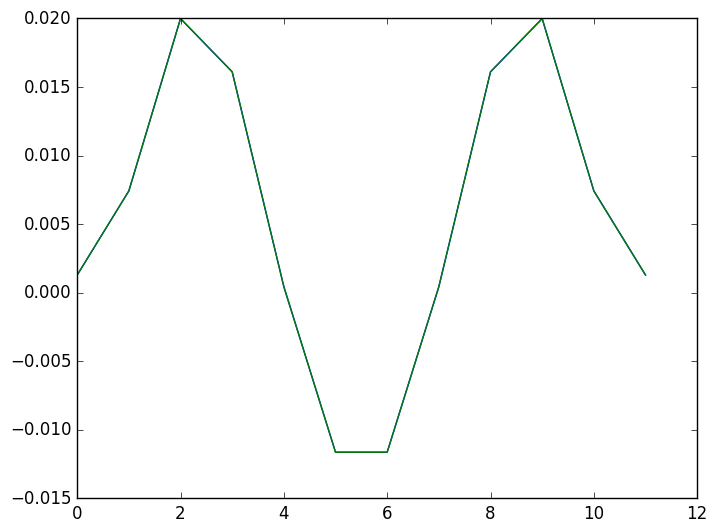

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd31e0ad810>

In [17]:
plot(sp_gam[10,1:n_span])
plot(gam_other[10,:])
#plot(a03d[10,:])
#plot(a0dot3d[10,:])

In [13]:
W_alpha = zeros(nsteps,n_span)
W_h = zeros(nsteps,n_span)
W_hdot = zeros(nsteps,n_span)
W_u = zeros(nsteps,n_span)
W_u[:,:] = 1
W_alpha[:,:] = 5*pi/180
for i = 1:nsteps
    for j = 1:n_span
        hdef = CosDef(0., h_amp[j], w, 0.)
        tt = W_mat[1][i,1]    
        W_h[i,j] = hdef(tt)*c
        W_hdot[i,j] = ForwardDiff.derivative(hdef,tt)*u
    end
end


In [14]:
W_cn = zeros(nsteps)
W_cs = zeros(nsteps)
W_cl = zeros(nsteps)
W_cd = zeros(nsteps)
W_cdi = zeros(nsteps)

cn3d = zeros(nsteps, n_span)
cs3d = zeros(nsteps, n_span)
cl3d = zeros(nsteps, n_span)
cd3d = zeros(nsteps, n_span)

for i = 1:nsteps
    W_cn[i] = 0
    W_cs[i] = 0
    for j = 1:n_span
        cn3d[i,j] = W_mat[j][i,10] + (2*pi/u)*(W_u[i,j]*cos(W_alpha[i,j]) + W_hdot[i,j]*sin(W_alpha[i,j]))*a03d[1,j] + (2*pi*c/u)*(3*a0dot3d[i,j]/4)
        cs3d[i,j] = W_mat[j][i,11] + 2*pi*a03d[i,j]^2
        cl3d[i,j] = cn3d[i,j]*cos(W_alpha[i,j]) + cs3d[i,j]*sin(W_alpha[i,j])
        cd3d[i,j] = cn3d[i,j]*sin(W_alpha[i,j]) - cs3d[i,j]*cos(W_alpha[i,j]) 
        W_cn[i] = W_cn[i] + cn3d[i,j]*sin(psi[j])*dpsi/2
        W_cs[i] = W_cs[i] + cs3d[i,j]*sin(psi[j])*dpsi/2
        W_cl[i] = W_cl[i] + cl3d[i,j]*sin(psi[j])*dpsi/2
        W_cd[i] = W_cd[i] + cd3d[i,j]*sin(psi[j])*dpsi/2
    end
end


#cn_w = 

#sum_bcoeff = 0
#    for n = 1:n_bterm
#        if rem(n,2) != 0
#            sum_bcoeff = sum_bcoeff + b_coeff[n]
#        end
#    end

#    cnc_f[i] = -2*pi*(u[i]*cos(alpha[i])/surf.uref + hdot[i]*sin(alpha[i])/surf.uref)*(sum_bcoeff)
#    sum_bdot = 0
#        for n = 1:n_bterm
#            if rem(n,2) != 0
#                sum_bdot = sum_bdot + bdot[n]
#            end
#        end
#        cnnc_f[i] = -(2*pi*surf.c/(surf.uref))*(3*sum_bdot/4)
#    end

In [15]:
dlt = readcsv("../test/anto_cl.csv")
plot(dlt[:,1]/T,dlt[:,2])
t_th = W_mat[1][:,1]*c_d/u_d
range = round(Int,(ncyc-1)*nsteps/ncyc)+1:nsteps
tbyT = (t_th-t_th[1])/T
plot(tbyT,W_cl[range])




LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError(u'x and y must have same first dimension',)
  File "/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/pyplot.py", line 3154, in plot
    ret = ax.plot(*args, **kwargs)
  File "/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/__init__.py", line 1812, in inner
    return func(ax, *args, **kwargs)
  File "/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/axes/_axes.py", line 1424, in plot
    for line in self._get_lines(*args, **kwargs):
  File "/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 386, in _grab_next_args
    for seg in self._plot_args(remaining, kwargs):
  File "/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 364, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "/home/kiran/anaconda3/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 223, in _xy_from_xy
    raise ValueError("x and y must have same first dimension")

while loading In[15], in expression starting on line 6

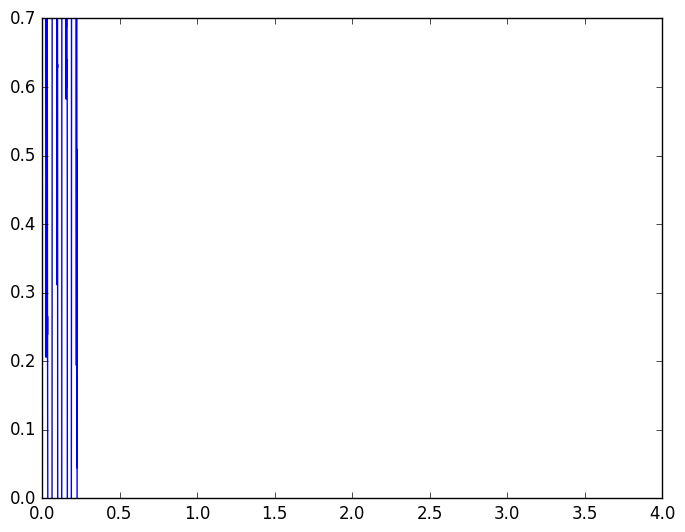

4-element Array{Float64,1}:
 0.0
 4.0
 0.0
 0.7

In [16]:
plot(W_mat[1][:,1]*c_d/u_d,W_cl)
PyPlot.axis([0,4,0.0,0.7])

In [ ]:
plot(W_mat[1][:,1]*c_d/u_d,cd_ind/6)
#PyPlot.axis([0,120,0,1])

In [ ]:
W_mat[1]

In [ ]:
W_mat[2]

In [91]:
### Visualise the 3D problem
using PyPlot
pygui(true)
fig = figure()
ax = gca(projection="3d")

plot3D(map(q->q.x, W_surf[1].bv),map(q->q.z,W_surf[1].bv),-5.5,"y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[2].bv),map(q->q.z,W_surf[2].bv),-4.5,"y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[3].bv),map(q->q.z,W_surf[3].bv),-3.5,"y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[4].bv),map(q->q.z,W_surf[4].bv),-2.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[5].bv),map(q->q.z,W_surf[5].bv),-1.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[6].bv),map(q->q.z,W_surf[6].bv),-0.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[7].bv),map(q->q.z,W_surf[7].bv),0.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[8].bv),map(q->q.z,W_surf[8].bv),1.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[9].bv),map(q->q.z,W_surf[9].bv),2.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[10].bv),map(q->q.z,W_surf[10].bv),3.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[11].bv),map(q->q.z,W_surf[11].bv),4.5, "y",color = "black",linewidth=2.0)
plot3D(map(q->q.x, W_surf[12].bv),map(q->q.z,W_surf[12].bv),5.5, "y",color = "black",linewidth=2.0)


#scatter3D(map(q->q.x, W_curfield[1].tev),map(q->q.z,W_curfield[1].tev),-6,"z",s=20,c=map(q->q.s,W_curfield[1].tev),cmap=ColorMap("jet"),edgecolors="none")
#scatter3D(map(q->q.x, W_curfield[2].tev),map(q->q.z,W_curfield[2].tev),-2,"z",s=20,c=map(q->q.s,W_curfield[2].tev),cmap=ColorMap("jet"),edgecolors="none")
#scatter3D(map(q->q.x, W_curfield[3].tev),map(q->q.z,W_curfield[3].tev),-1,"z",s=20,c=map(q->q.s,W_curfield[3].tev),cmap=ColorMap("jet"),edgecolors="none")
#scatter3D(map(q->q.x, W_curfield[4].tev),map(q->q.z,W_curfield[4].tev),0,"z",s=20,c=map(q->q.s,W_curfield[4].tev),cmap=ColorMap("jet"),edgecolors="none")
#scatter3D(map(q->q.x, W_curfield[1].tev),map(q->q.z,W_curfield[1].tev),3,"z",s=20,c=map(q->q.s,W_curfield[1].tev),cmap=ColorMap("jet"),edgecolors="none")
#scatter3D(map(q->q.x, W_curfield[2].tev),map(q->q.z,W_curfield[2].tev),2,"z",s=20,c=map(q->q.s,W_curfield[2].tev),cmap=ColorMap("jet"),edgecolors="none")
#scatter3D(map(q->q.x, W_curfield[3].tev),map(q->q.z,W_curfield[3].tev),1,"z",s=20,c=map(q->q.s,W_curfield[3].tev),cmap=ColorMap("jet"),edgecolors="none")

scatter3D(map(q->q.x, W_curfield[1].tev),map(q->q.z,W_curfield[1].tev),-5.5,"z",s=20,c=map(q->q.s,W_curfield[1].tev),cmap=ColorMap("jet"),edgecolors="none")

scatter3D(map(q->q.x, W_curfield[6].tev),map(q->q.z,W_curfield[6].tev),-0.5,"z",s=20,c=map(q->q.s,W_curfield[6].tev),cmap=ColorMap("jet"),edgecolors="none")




axis("equal")
ax[:view_init](0, 10)




In [21]:
surf

surf (generic function with 5 methods)

In [22]:
W_surf

12-element Array{UNSflow.TwoDSurf,1}:
 UNSflow.TwoDSurf(1.0,1.0,"FlatPlate",0.0,70,35,UNSflow.KinemDef(UNSflow.ConstDef(0.0872665),UNSflow.CosDef(0.0,1.11014,1.00531,0.0),UNSflow.ConstDef(1.0)),[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0455303,0.0910607,0.136591,0.182121,0.227652,0.273182,0.318712,0.364243,0.409773,0.455303,0.500834,0.546364,0.591894,0.637425,0.682955,0.728485,0.774016,0.819546,0.865076,0.910607,0.956137,1.00167,1.0472,1.09273,1.13826,1.18379,1.22932